# Scania database

The database was released in 2016 at the IDA conference and is available on UCI.
It contains anonymised data from an Air Pressure System (APS), with the target of detecting future failures.

To avoid confusion, during this note, we will use the following norm:
- positive classification or class 1 means there is component failures of specific components of the APS system.
- negative classification or class 0 means there is a failure but not related to the APS

The advantage of this dataset is that it holds a commercial objective :
- false positive or type 1 error cost \$10, that is the cost of an unnecessary check required to be done by a mechanic at a workshop
- false negative or type 2 error cost \$500, refers to the value of missing a faulty truck, which may cause a breakdown.

The aim is to reduce the overall cost.
Solutions were unveiled during the conference: the best answer had a total cost of $9,920 for 9 undetected failure of the APS and 542 unnecessary checks.

This means that the recall was higher than 97\%, i.e. 97\% of the failures of the APS were detected.
It had a 40\% precision, meaning that 60\% of the APS flagged turned out to be "sound", and 40\% were indeed failing.

As we have a pre-existing benchmark, the aim will be to understand if it can be improved, and why. During the presentation, we will see why lies the detection difficulty and potential follow-up to improve it.

All the feature are positive integers : 
- 100 are "counters" that counts the occurrence of events known by a two-letter code.
- 7 "histograms" of 10 bins, which means that here this is a counting of a particular physical value being in a particular range (also known as "bucket"). 

We do not know what those are or the values of the ranges, but the presentation of the paper suggest they are open-ended.

The 7 histograms of physical histograms are known as AG, AY, AZ, BA, CN, CS and EE.

The description from the dataset also notes that the dataset is a subset that has been curated by experts.

The dataset is unbalanced, in the sense that there is less than 2\% of the positive class for more than 98\% of the negative class.

In [75]:
import pandas as pd
import numpy as np
import os
import xgboost
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score,precision_score,confusion_matrix,precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import shap

from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
from sklearn.linear_model import LogisticRegression

from scipy.stats import kurtosis, skew, ttest_ind
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import PercentFormatter, FuncFormatter
import matplotlib.patches as mpatches
import pandas_profiling

import seaborn as sns

import lightgbm as lgb
import os
import warnings

from common import *
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('aps_failure_training_set.csv',skiprows=20)
test = pd.read_csv('aps_failure_test_set.csv',skiprows=20)
train["origin"] = "train"
test["origin"] = "test"
data= pd.concat([train,test])

In [3]:
columns_list = train.columns

all_columns_with_tags = [a for a in columns_list if "_" in a]
all_tags = [get_tag(a) for a in all_columns_with_tags]
hists = [k for k,v in Counter(all_tags).items() if v == 10]
hists_columns = [k for k in all_columns_with_tags if get_tag(k) in hists]
hists_dict = {k:[col for col in hists_columns if k in col] for k in hists if get_tag(k) in hists}
counter_columns = [k for k in all_columns_with_tags if get_tag(k) not in hists]

In [4]:
#to avoid double index
data = data.reset_index()

In [5]:
data = pre_processing(data,np.nan)



## Missing values

Looking at the missing values per feature we notice that we have a very high rate of missing values for some features and also that we have the exact same number of missing values in a feature in the train and test set.

Also, the lowest level of missing features is for the features that are part of the histograms, we will look at then first.

In [6]:
missing_values = data[data.origin=="train"].apply(lambda x: sum(x.isna())/len(x)).to_frame().rename(columns={0:"train"})
missing_values["test"] = data[data.origin=="test"].apply(lambda x: sum(x.isna())/len(x))
missing_values = missing_values.sort_values("train",ascending=False)




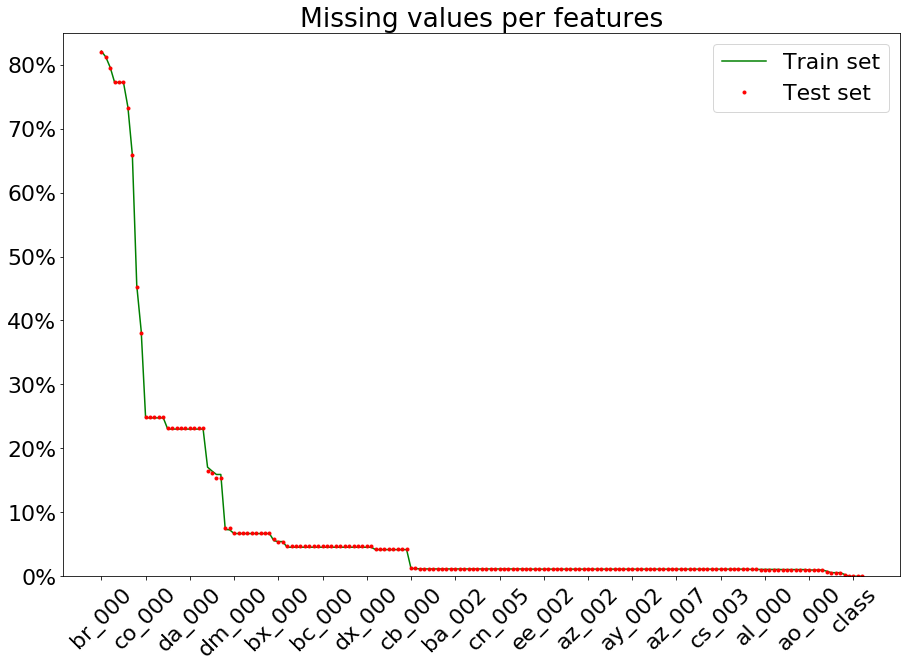

In [7]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
plt.rc('font', **font)
plt.figure(figsize=(15,10));


plt.plot(missing_values.train, 'g-',label="Train set",)
plt.plot(missing_values.test,'r.',ms=6,label="Test set")
ax = plt.gca()
ax.set_xticks(missing_values.index[::10])
ax.set_xticklabels(missing_values.index[::10], rotation=45)
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.legend();
plt.ylim(0,0.85);
plt.title("Missing values per features");

In [8]:
#For data exploration and graph
#all numeric is all columns tranformed to numeric with na as - 1
data = data.replace(np.nan,-1)
data = data.rename(columns={"class":"Class"}) #to avoid name collision with the class

## The histograms

There are 860 missing values, but when there is a missing value in a histogram, all the values in the histograms are missing.

First let's have a look at ten histograms, five from the positive class and five from the negative class.

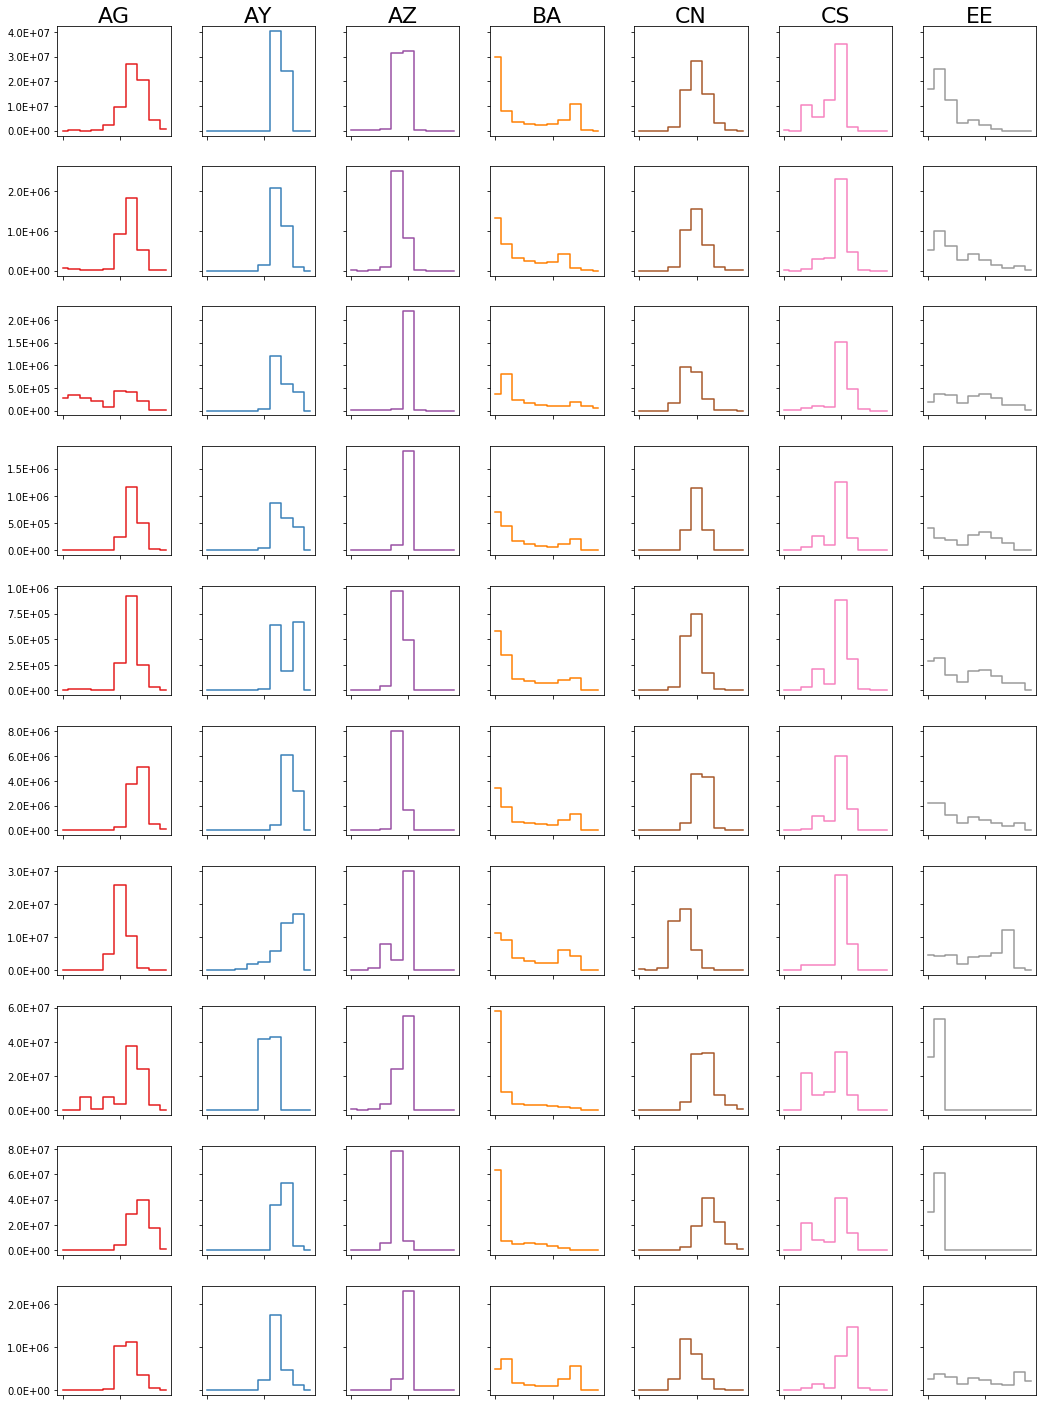

In [9]:
fig , axs = plt.subplots(10,7,sharex=True,  sharey='row',figsize=(15,20))
cmap=plt.cm.get_cmap('Set1', 7)
df_top = data[(data.Class==0)&(data["ag_000"]>0)]
for axis,r in zip(axs,df_top.sample(5).iterrows()):
    for i,(ax,hist) in enumerate(zip(axis,hists)):
        ax.step(range(10),r[1][f"{hist}_000":f"{hist}_009"],where="mid",color=cmap(i))
        ax.tick_params(labelbottom=False)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "%.1E"%x))
        ax.tick_params(axis='y', which='major', labelsize=10)
df_bottom = data[(data.Class==1)&(data["ag_000"]>0)]
for axis,r in zip(axs[5:],df_top.sample(5).iterrows()):
    for i,(ax,hist) in enumerate(zip(axis,hists)):
        ax.step(range(10),r[1][f"{hist}_000":f"{hist}_009"],where="mid",color=cmap(i))
        ax.tick_params(labelbottom=False)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x,pos: "%.1E"%x))
        ax.tick_params(axis='y', which='major', labelsize=10)

for ax,hist in zip(axs[0],hists):
    ax.set_xlabel(hist.upper())    
    ax.xaxis.set_label_position('top') 
plt.tight_layout()

In [10]:
for hist in hists:
    data[f"{hist}_total"] = sum(data[col] for col in hists_dict[hist])
data["system_age"] = data[[f"{hist}_total" for hist in hists]].max(axis=1)
data = data.replace(-10,-1) #Some totals of -1 to make it easy to detect NA
#data = data.drop([f"{hist}_total" for hist in hists],axis=1)

### Histogram features

When looking at the histograms, we notice they have the same surface.
Indeed if we add the histograms values for each measurement that are the same (when there are not missing).

This means that all measurements are taken at the same moment.

This is also a way to measure the age of the APS .

We add a feature called 'system_age' that is the sum for features for one of the histograms (they are in practice equal).

Now let's look at the distribution of this "system_age" feature depending on whether the system is failing or sound.

Apart from a group of APS that have no measurements, we notice that failing systems have more measures than none failing system. Assuming the frequency for those measurements is the same across systems, this means that failing systems tend to be older systems.


The graph is scaled to have the same surface, we cannot compare the value between the figure, but we can already notice that the system that fails are usually older than "younger" system which should not come are a surprise.


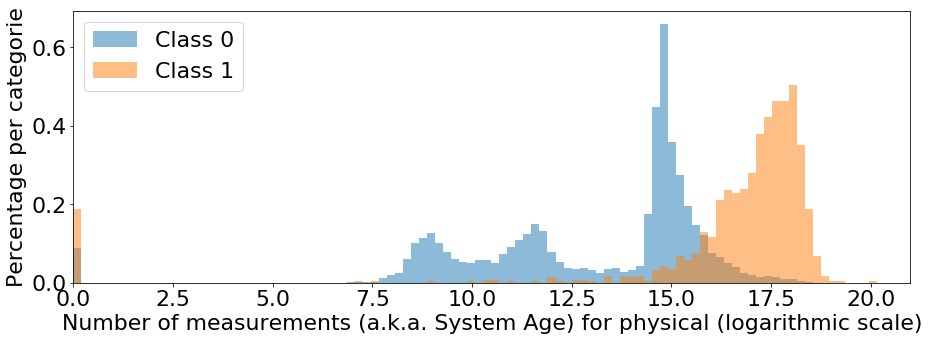

In [11]:
plt.figure(figsize=(15,5));
for_plotting = data[data.system_age>=0]
_,bins,_ = plt.hist(np.log(for_plotting[for_plotting.Class==0].system_age+1),bins=100,density=True,alpha=0.5,label="Class 0");
plt.hist(np.log(for_plotting[for_plotting.Class==1].system_age+1),bins=bins,density=True,alpha=0.5,label="Class 1");
plt.legend();
plt.ylabel("Percentage per categorie");
plt.xlabel("Number of measurements (a.k.a. System Age) for physical (logarithmic scale)");
plt.xlim(0,21);

## Distribution of the measurements

To make the graph readable, it has been scaled using the width.

There is the same number of points per categories; this means that when there is a spike, this does not mean that there is fewer values, but that all values are the same.

This means that for class 0, they are as many points for ay_000 and ay_008, but almost ay_00 values are 0.

Also given the range of the distribution for the number of occurrence in each category, the number of events is using a logarithmic scale.

For example, we notice some distribution difference between the class for the variables ag_002 and cn_002; we will zoom in into those 2 features.

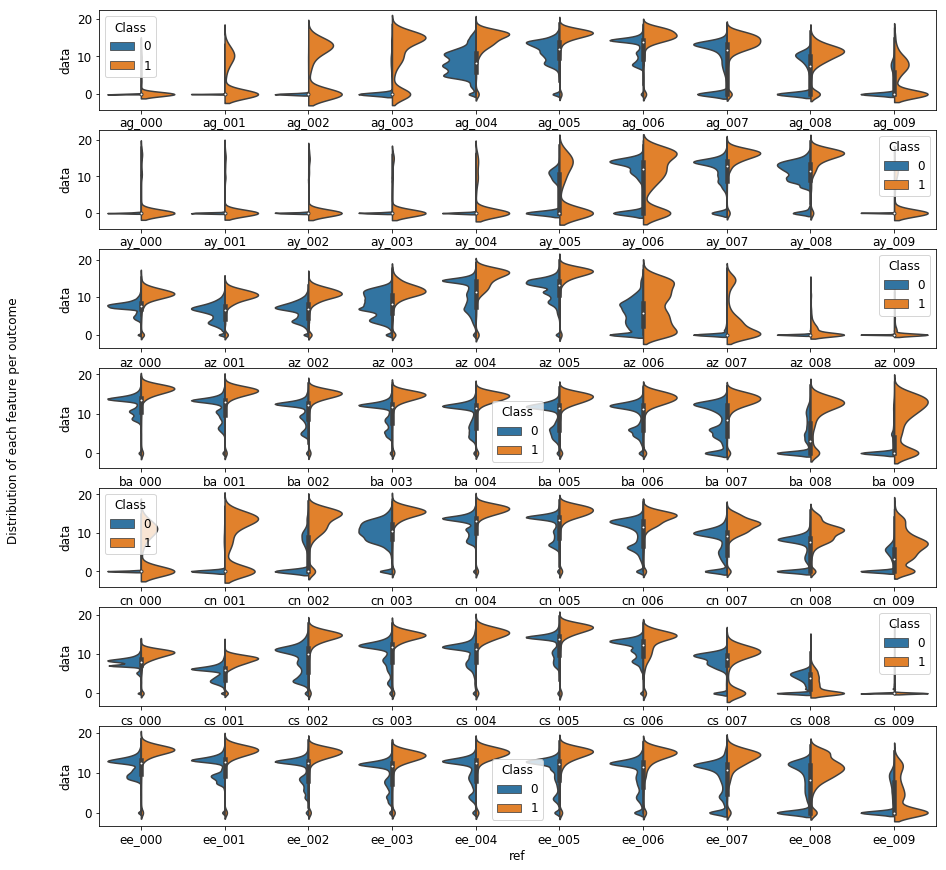

In [12]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
df_dist = {}
for dist in hists:
    pds_to_concat = []
    for i,col in enumerate(hists_dict[dist]):
        temp = data[[col,'Class']]
        temp["ref"] = col
        temp.loc[temp[col]>=0,col] = np.log(temp[col]+1)
        temp.columns = ["data","Class","ref"]
        pds_to_concat.append(temp)
    df_dist[dist] = pd.concat(pds_to_concat)
    df_dist[dist] = df_dist[dist][df_dist[dist].data>=0] # No NA values
#ag_dist.data = np.log(ag_dist.data+1)
fig , axs = plt.subplots(7)
fig.set_figheight(15)
fig.set_figwidth(15)
#sns.boxenplot(data=ag_dist,x="ref",y="data",hue="class",outlier_prop=0.00000000001)
for i,hist in enumerate(hists):
    sns.violinplot(data=df_dist[hist],x="ref",y="data",hue="Class",scale="width",scale_hue=True
                   , split=True,ax=axs[i],legend=(i==0));
fig.text(0.04, 0.5, 'Distribution of each feature per outcome', va='center', rotation='vertical');

### Feature AG_002 distribution

Let's look at the variation of the failure rate depending of the number of occurence of AG_002.

First we select all the system for which there is no occurence of AG in the range 2 (the thirds range), said differently those are the system for which AG_002 is 0.

They represent in practice the majority of the system.

The of the APS are divided in 20 buckets of equal size (200 each).

The percentage of failure goes from a few percent for the lower values, to more than 90\% for the top 200 values.

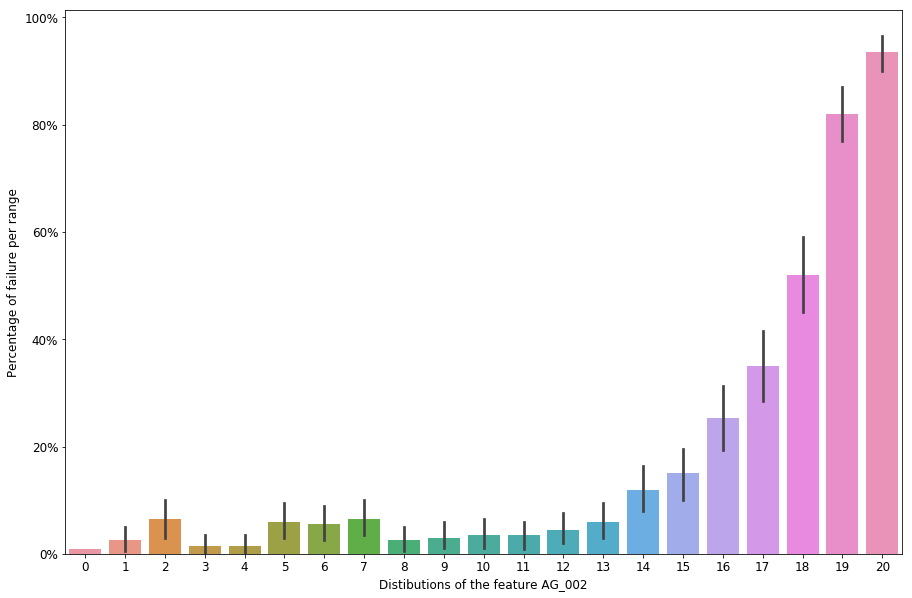

In [13]:
variable =  "ag_002"
bucket_nb = 20 

_ , bins = pd.qcut(np.log(data[data[variable]>0][variable]),bucket_nb,retbins=True)
data[f"{variable}_buckets"] = pd.cut(np.log(data[variable]+1),[-0.1] + list(bins),labels=range(bucket_nb+1))
#pd.crosstab(data[f"{variable}_buckets"],data.Class,margins=True)
plt.figure(figsize=(15,10));
ax = sns.barplot(data=data,x=f"{variable}_buckets", y="Class")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Distibutions of the feature AG_002");
plt.ylabel("Percentage of failure per range");



### Feature CN_001 distribution

We will do the same with the same with the feature CN_001.

First, we select all the system for which there is no occurrence of CN in the range 1 (the second interval), said differently those are the system for which CN_001 is 0.

They represent in practice the majority of the systems here again.

The rest of the APS are divided into 20 buckets of equal size (200 each).

The percentage of failure goes from a few percents for the lower values to more than 70\% for the top 200 values, still very useful for detecting failing system but not as precise as AG_002.

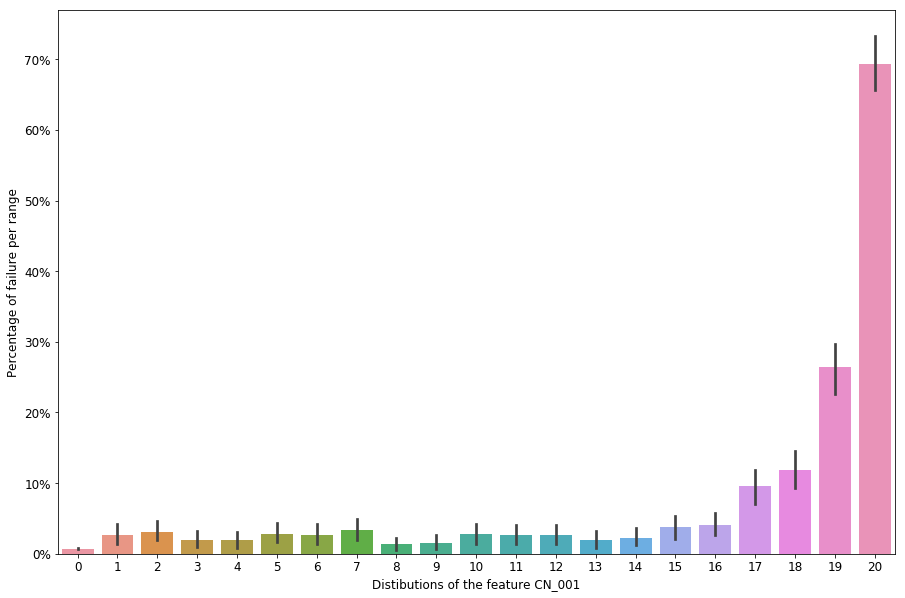

In [14]:
variable =  "cn_001"
bucket_nb = 20 
_ , bins = pd.qcut(np.log(data[data[variable]>0][variable]),bucket_nb,retbins=True)
data[f"{variable}_buckets"] = pd.cut(np.log(data[variable]+1),[-0.1] + list(bins),labels=range(bucket_nb+1))
#pd.crosstab(data[f"{variable}_buckets"],data.Class,margins=True)
plt.figure(figsize=(15,10));
ax = sns.barplot(data=data,x=f"{variable}_buckets", y="Class")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Distibutions of the feature CN_001");
plt.ylabel("Percentage of failure per range");

### Potential interaction between AG_002 and CN_001

We have looked at the potential of using AG_002 and CN_001 for detecting failing system, not let's look at the possibility of looking at those 2 variables at the same time.

Given the distribution of AG_002 and CN_001, the diagramme below is also using a logarithmic scale for both AG_002 ad CN_001.

In different of blue is the "sound" system.

In the different red is the failing system.

When you have a  red cell, you have a majority of class 1 APS.

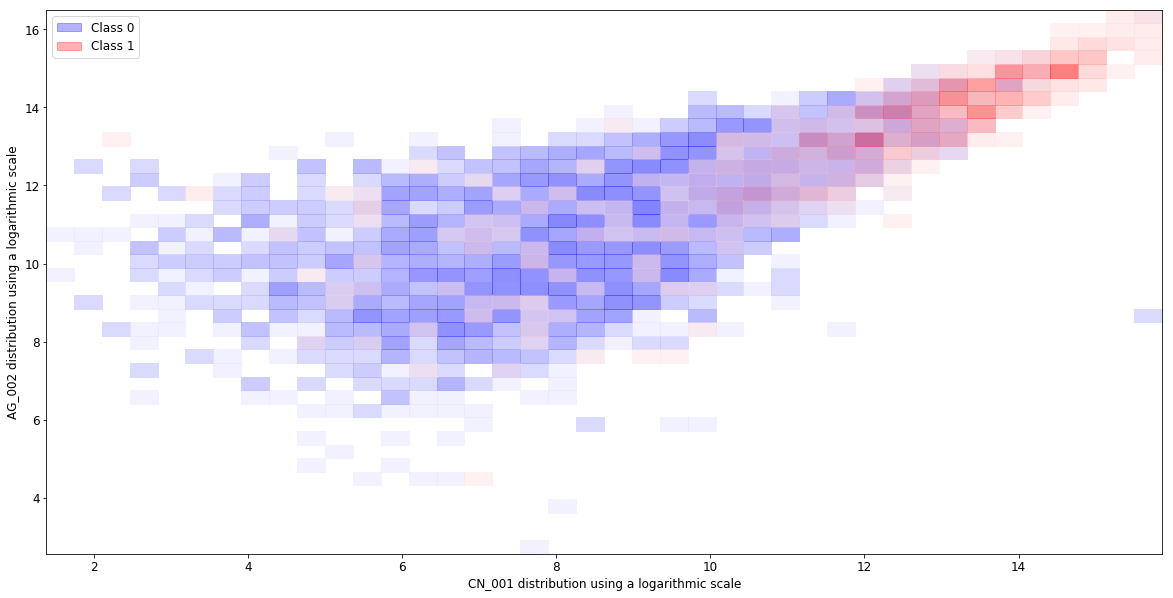

In [15]:
plt.figure(figsize=(20,10))

df = data[(data.Class==0)&(data.ag_002>0)&(data.cn_001>0)]
cmap = sns.light_palette("blue", as_cmap=True)
_,xedges,yedges, _ = plt.hist2d(np.log(df["ag_002"]+2), np.log(df["cn_001"]+1),norm=LogNorm()
                                , bins=40,cmap=cmap, cmin=1,alpha=0.5,label="Sound APS");
df = data[(data.Class==1)&(data.ag_002>0)&(data.cn_001>0)]

class_0 = mpatches.Patch(color='blue',alpha=0.3, label='Class 0')
class_1 = mpatches.Patch(color='red',alpha=0.3, label='Class 1')
plt.legend(handles=[class_0,class_1],loc=2)

cmap = sns.light_palette("red", as_cmap=True)
plt.hist2d(np.log(df["ag_002"]+1)
                , np.log(df["cn_001"]+1), cmap=cmap,bins=[xedges,yedges], cmin=1
                ,alpha=0.5
                ,label="Failing APS");
plt.ylabel("AG_002 distribution using a logarithmic scale");
plt.xlabel("CN_001 distribution using a logarithmic scale");

As we can notice, there is a strong correlation between the age of the system and its risk of failing, which makes sense intuitively.

# Null values

There also seems to be a lot of Null values... Let's check it out.


In [16]:
null_values = data[data.origin=="train"][counter_columns].apply(lambda x: sum(x==0)/len(x)).to_frame().rename(columns={0:"train"})
null_values["test"] = data[data.origin=="test"][counter_columns].apply(lambda x: sum(x==0)/len(x))
null_values = null_values.sort_values("train",ascending=False)




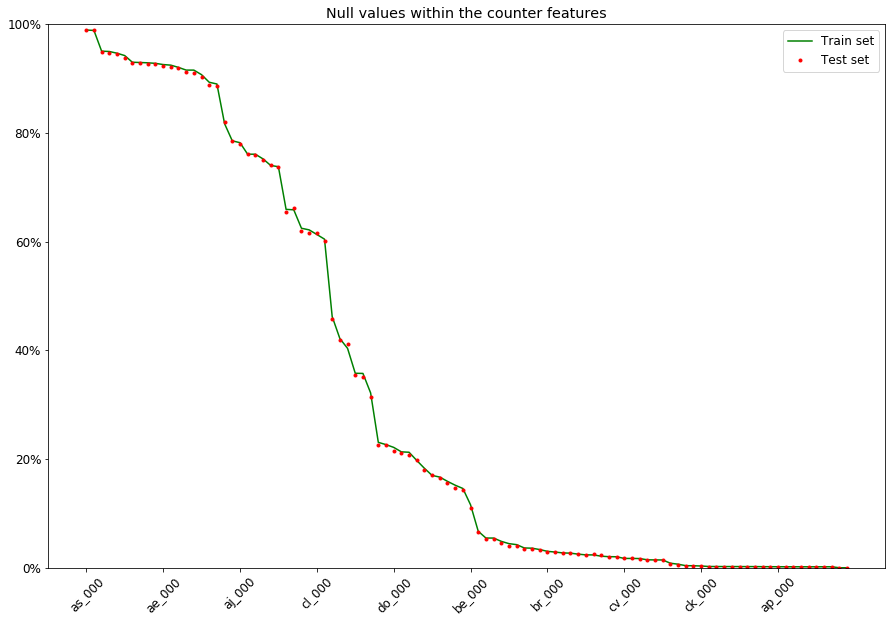

In [17]:
plt.figure(figsize=(15,10));
plt.plot(null_values.train, 'g-',label="Train set",)
plt.plot(null_values.test,'r.',ms=6,label="Test set")
ax = plt.gca()
ax.set_xticks(null_values.index[::10])
ax.set_xticklabels(null_values.index[::10], rotation=45)
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.legend();
plt.ylim(0,1);
plt.title("Null values within the counter features");

In [18]:
null_values.head()

,train,test
as_000,0.989167,0.989250
au_000,0.988500,0.988688
ef_000,0.950350,0.947937
dz_000,0.949733,0.947375
eg_000,0.946567,0.944187


## First attempt using lightGBM

Before we go down too deep in feature engineering, let's test what kind of precision we can have, this will also give us some insights on how the data behaves.

There are a significant number of missing values and the scale of the variables that have very high values, but we can still use a tree-based method that handles missing values like lightGBM.

As we can see from the precision/recall curve, this first modeling is already very close to the reference solution that has been published.

Looking at the recall of the model depending of the system age, our worst recall is worse for "younger" system at 77\% and the best recall for the "older" system at more than 90\%. As a reminder the best publisher solution had a recall of 97\%.

In [19]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
params ={'boosting_type': 'gbdt',
 'objective': 'binary',
 'metric': 'binary_logloss',
 'num_leaves': 31,
 'learning_rate': 0.1,
 'verbose': 0,
 'lambda_l1':0, } #defautl values it 0
pred_prob_valid = []
X_valids = []
y_valids = []
eval_results = []
train = data[data.origin=="train"].replace(-1,np.nan) #
#the_total_columns = [f"{hist}_total" for hist in hists]
X = train.drop(["Class","origin","index"],axis=1)#[["aa_000","ci_000","bt_000","total_max","ag_002","ay_006_density"]] #,"aa_000","ci_000","bt_000","ck_000"],axis=1)
Y = train.Class
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
for train_index, valid_index in skf.split(X, Y):
    evals_result = {}
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,free_raw_data=False)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=150,
                valid_sets=lgb_eval,  # eval training data
                #fobj= logregobjspecial(beta),
                #feval=create_evalmoney(treshold),
                evals_result=evals_result,
                verbose_eval=False,
               )
    eval_results.append(evals_result)
    pred_prob = gbm.predict(X_valid)
    pred_prob_valid.append(pred_prob)
    y_valids.append(y_valid)
    X_valids.append(X_valid)

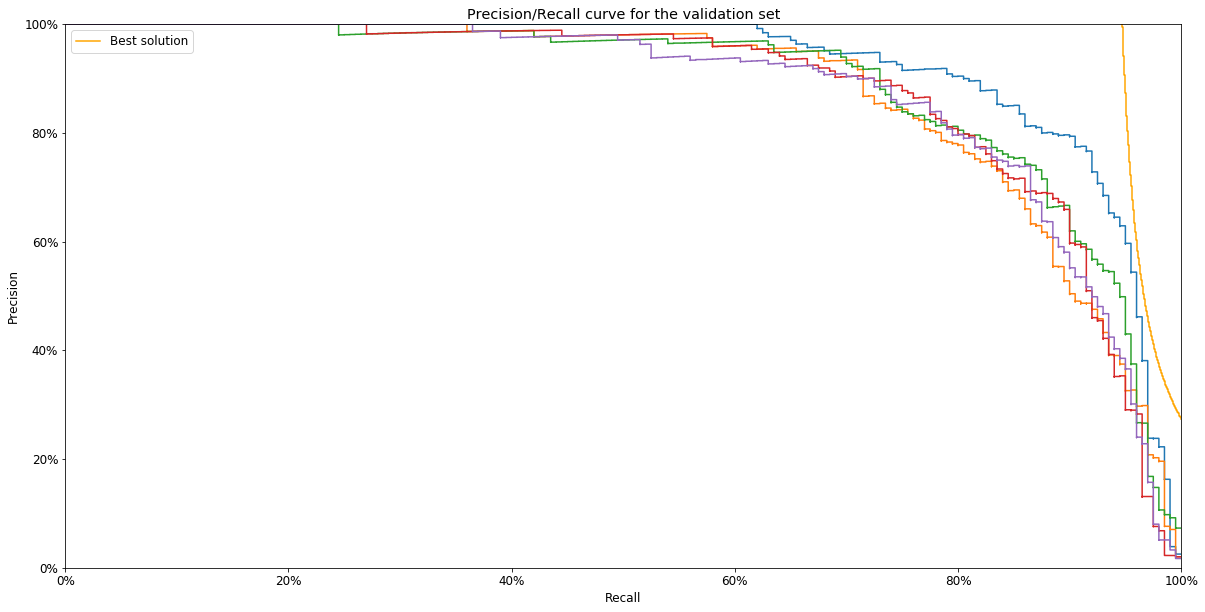

In [20]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
for y,pred in zip(y_valids,pred_prob_valid):
    pred = 1. / (1. + np.exp(-pred))
    graph_curve(y,pred)

best_limit_x = []
best_limit_y = []
for false_neg in range(0,200):
    false_neg = false_neg/10
    true_pos = 375 - false_neg
    recall = true_pos/375
    false_pos = 9920/10 - 50*false_neg
    precision = true_pos/(true_pos+false_pos)
    best_limit_x.append(recall)
    best_limit_y.append(precision)
    
plt.step(best_limit_x,best_limit_y,color="orange",label="Best solution")
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.xaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0,1);
plt.xlim(0,1);
plt.title("Precision/Recall curve for the validation set");

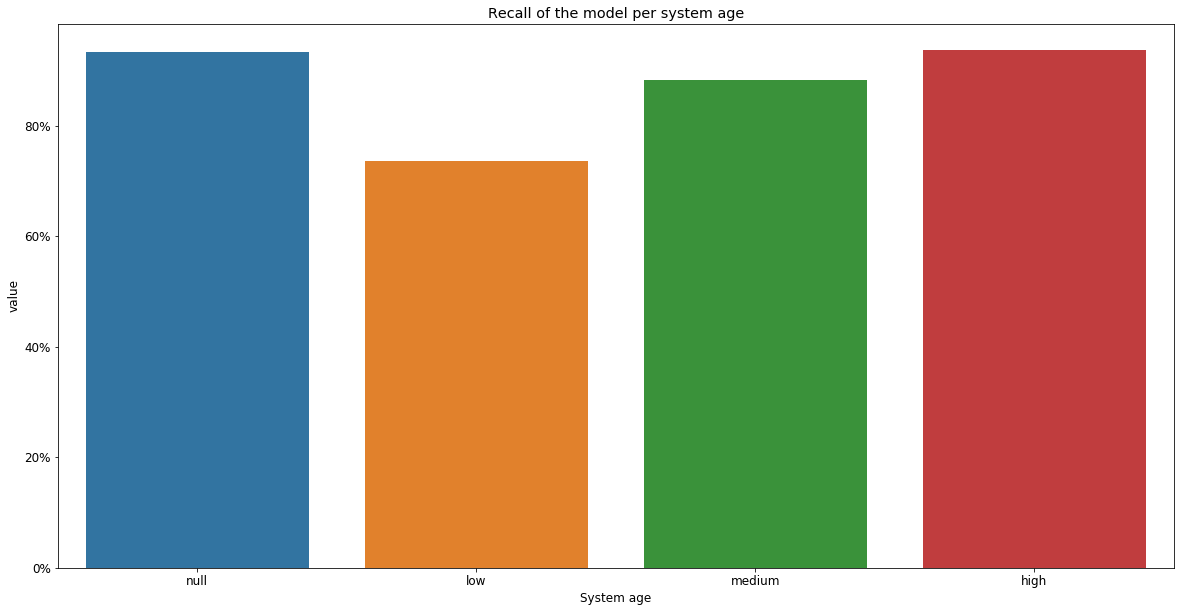

In [21]:
results = pd.concat(X_valids)
results["class"] = pd.concat(y_valids)
results["predicted_probability"] = pd.concat([pd.Series(p,index=y.index) for y,p in zip(y_valids,pred_prob_valid)])#pd.concat([pd.Series(1. / (1. + np.exp(-p)),index=y.index) for y,p in zip(y_valids,pred_prob_valid)])
results["predicted_class"] = results.predicted_probability >= 0.05
results["accuracy"] = results.predicted_class == (results["class"] ==  1)
results["interest"] = (results["class"] == 1)|(results.predicted_class == True)
#We look for bin of equal size for the feature total, withotut he exception of the null values and NA
_, bins_for_total_feature = pd.qcut(results[(results["class"]==1)&(results.system_age>0)].system_age,3,retbins=True)
bins_for_total_feature[0]=0.0001 # laking sure the first bin limit is above 0
results = results.replace(np.nan,-1)
results["system_age"], total_bins = pd.cut(results.system_age,[-10.1] + list(bins_for_total_feature),
                             labels=["null","low", "medium", "high"],retbins=True)
df_temp = results[results["class"]==1]
ct = pd.crosstab(df_temp["system_age"],results["accuracy"],normalize="index")
stacked = ct.stack().reset_index().rename(columns={0:'value'})
to_show = stacked[stacked.accuracy==True]
ax = sns.barplot(data=to_show ,x="system_age", y="value")
plt.xlabel("System age")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Recall of the model per system age");

In [22]:
to_show

,system_age,accuracy,value
1,null,True,0.933333
3,low,True,0.736677
5,medium,True,0.883648
7,high,True,0.937107


### Optimized LightGBM model.

As we already have very good precision/recall curves, let's optimize the model.

The optmization I used Bayes optimizitation to reduce the time of calculations, using custom loss function and custom objective function that matched the commercial objective of the overall goal.

After a couple off test, it turns out that using a customer loss function does not change the overall performance of the model as describe by a "precision_recall" function, but it does allow for better performance in our case as we can better define a treshold for our decision function.

The parameters where selected using crossvalidating using stratifield KFold.

As is it better to train the lightGBM model with an evaluation set, we will do a train/validation split, find the best performing decision treshold on the decision function on the validation test and then apply it to the test set.

In [23]:
col_list=(list(columns_list) + ["Class","system_age"])
col_list.remove("class")

data_for_lightgbm = data[col_list].copy()

In [24]:
X = data_for_lightgbm[data_for_lightgbm.origin=="train"].drop(["Class","origin"],axis=1)
y = data_for_lightgbm[data_for_lightgbm.origin=="train"]["Class"]

In [25]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
params = {'boosting_type': 'gbdt',
 'feature_fraction': 0.3768261055064843,
 'learning_rate': 0.0668457974368219,
 'max_depth': 6,
 'min_child_samples': 220,
 'min_child_weight': 27.460369817131145,
 'num_leaves': 590,
 'reg_alpha': 0.4999057288562867,
 'reg_lambda': 0.29964409552070514,
 'subsample': 0.7553625889348823,
 'subsample_for_bin': 180000,
 'is_unbalanced': False,
 'scale_pos_weight': 58.298024096093584}

treshold = 0.08174049320688517
beta = 7.514521379406827
num_boost_rounds = 192
pred_prob_valid = []
X_valids = []
y_valids = []
eval_results = []
train = data_for_lightgbm[data_for_lightgbm.origin=="train"].replace(-1,np.nan) #
#the_total_columns = [f"{hist}_total" for hist in hists]
X = train.drop(["Class","origin"],axis=1)#[["aa_000","ci_000","bt_000","total_max","ag_002","ay_006_density"]] #,"aa_000","ci_000","bt_000","ck_000"],axis=1)
Y = train.Class
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
for train_index, valid_index in skf.split(X, Y):
    evals_result = {}
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    lgb_train = lgb.Dataset(X_train, y_train,free_raw_data=False)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,free_raw_data=False)
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=num_boost_rounds,
                valid_sets=lgb_eval,  # eval training data
                fobj= logregobjspecial(beta),
                feval=create_evalmoney(treshold),
                evals_result=evals_result,
                verbose_eval=False,
               )
    eval_results.append(evals_result)
    pred_prob = gbm.predict(X_valid)
    pred_prob_valid.append(pred_prob)
    y_valids.append(y_valid)
    X_valids.append(X_valid)

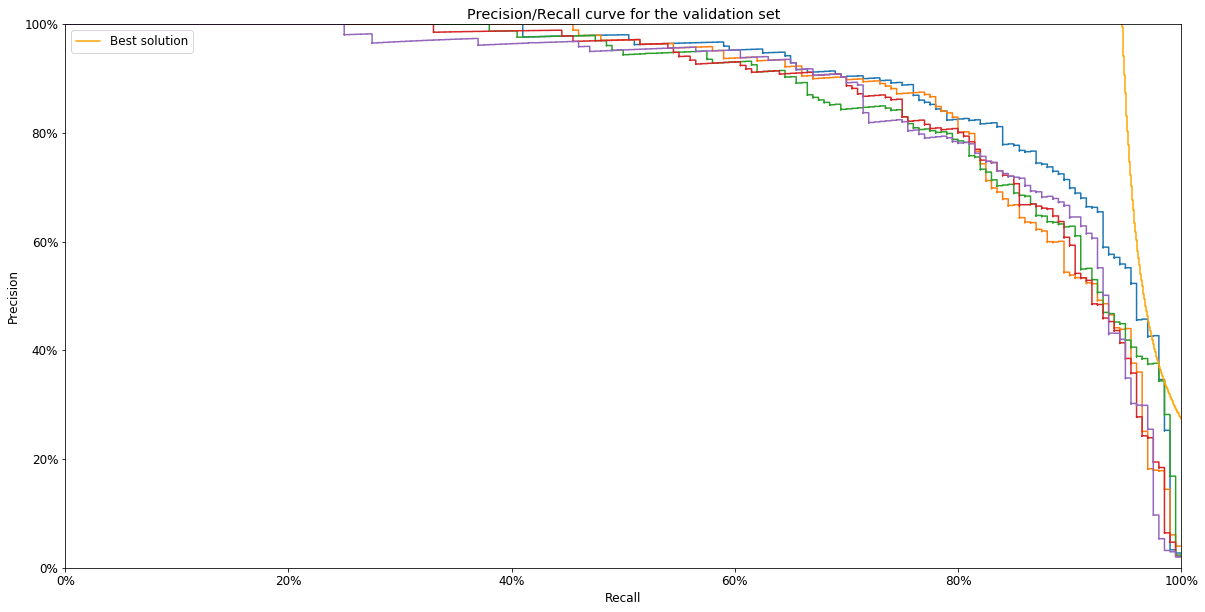

In [26]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
for y,pred in zip(y_valids,pred_prob_valid):
    pred = 1. / (1. + np.exp(-pred))
    graph_curve(y,pred)

best_limit_x = []
best_limit_y = []
for false_neg in range(0,200):
    false_neg = false_neg/10
    true_pos = 375 - false_neg
    recall = true_pos/375
    false_pos = 9920/10 - 50*false_neg
    precision = true_pos/(true_pos+false_pos)
    best_limit_x.append(recall)
    best_limit_y.append(precision)
    
plt.step(best_limit_x,best_limit_y,color="orange",label="Best solution")
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.xaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0,1);
plt.xlim(0,1);
plt.title("Precision/Recall curve for the validation set");

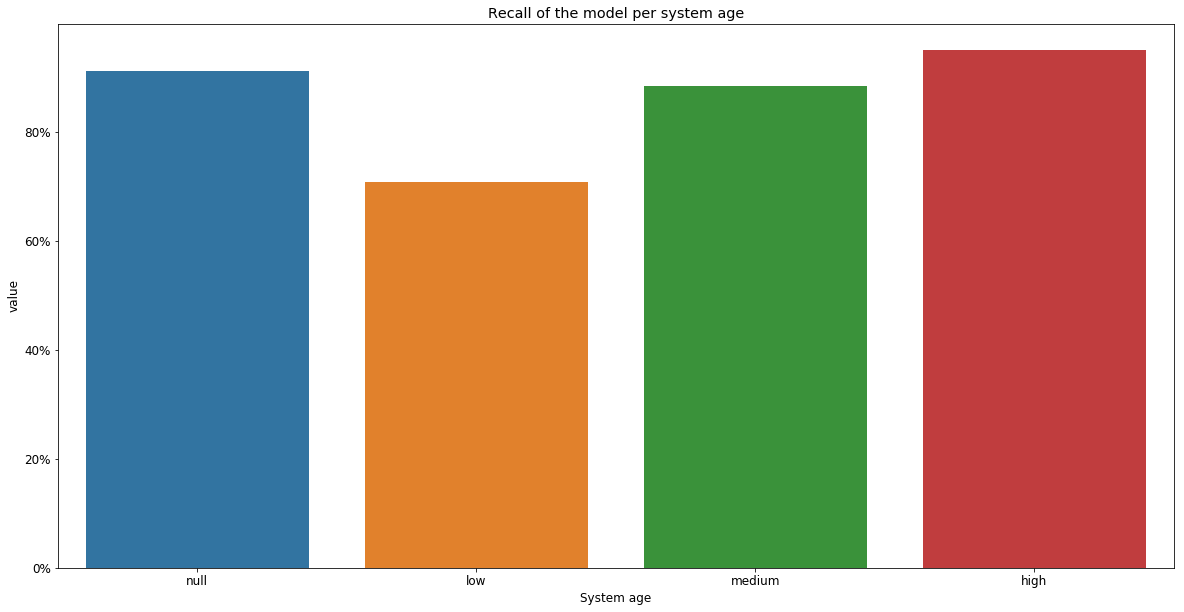

In [27]:
results = pd.concat(X_valids)
results["class"] = pd.concat(y_valids)
results["predicted_probability"] = pd.concat([pd.Series(p,index=y.index) for y,p in zip(y_valids,pred_prob_valid)])#pd.concat([pd.Series(1. / (1. + np.exp(-p)),index=y.index) for y,p in zip(y_valids,pred_prob_valid)])
results["predicted_class"] = results.predicted_probability >= treshold
results["accuracy"] = results.predicted_class == (results["class"] ==  1)
results["interest"] = (results["class"] == 1)|(results.predicted_class == True)
#We look for bin of equal size for the feature total, withotut he exception of the null values and NA
_, bins_for_total_feature = pd.qcut(results[(results["class"]==1)&(results.system_age>0)].system_age,3,retbins=True)
bins_for_total_feature[0]=0.0001 # laking sure the first bin limit is above 0
results = results.replace(np.nan,-1)
results["system_age"], total_bins = pd.cut(results.system_age,[-10.1] + list(bins_for_total_feature),
                             labels=["null","low", "medium", "high"],retbins=True)
df_temp = results[results["class"]==1]
ct = pd.crosstab(df_temp["system_age"],results["accuracy"],normalize="index")
stacked = ct.stack().reset_index().rename(columns={0:'value'})
to_show = stacked[stacked.accuracy==True]
ax = sns.barplot(data=to_show ,x="system_age", y="value")
plt.xlabel("System age")
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.title("Recall of the model per system age");

In [28]:
to_show

,system_age,accuracy,value
1,null,True,0.911111
3,low,True,0.708464
5,medium,True,0.883648
7,high,True,0.949686


In [29]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [34]:
explainer = shap.TreeExplainer(gbm)

all_X_valid = pd.concat(X_valids)
all_y_valid = pd.concat(y_valids)

# Shapley values

The Shap library allows us to look at the feature that drive the classifier in general, but also for particular values.

On the validation set, we can for example focus of the Class 1

## Feature importance for the complete validation set (concatenated)

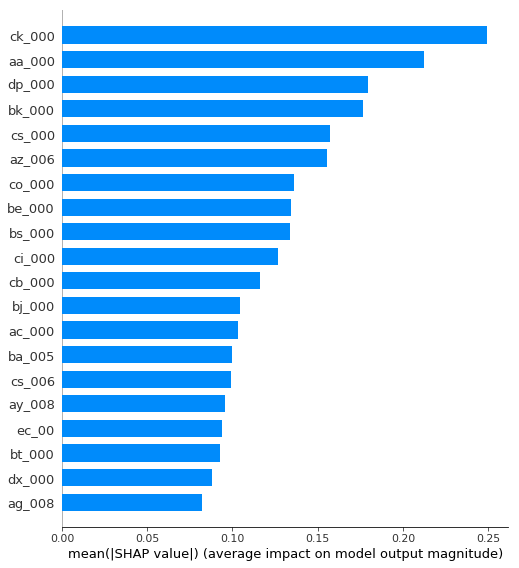

In [36]:
shap_values = explainer.shap_values(all_X_valid)
shap.summary_plot(shap_values,all_X_valid, plot_type="bar")

## Feature importance for the Class 1

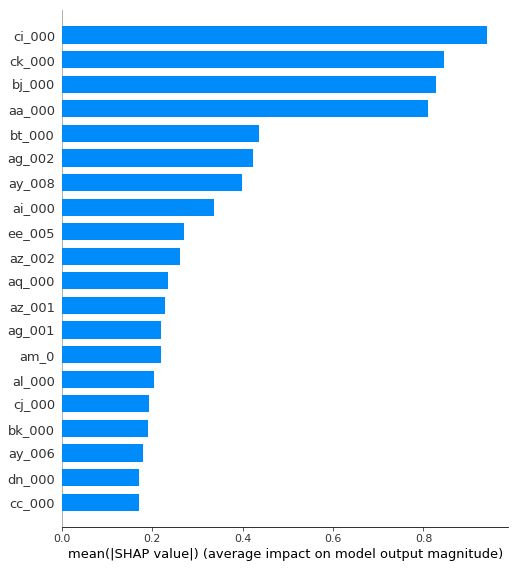

In [37]:
shap_values = explainer.shap_values(all_X_valid[all_y_valid==1])
shap.summary_plot(shap_values,all_X_valid[all_y_valid==1], plot_type="bar")

## Individual contribution for Class 1 on the validation datasets

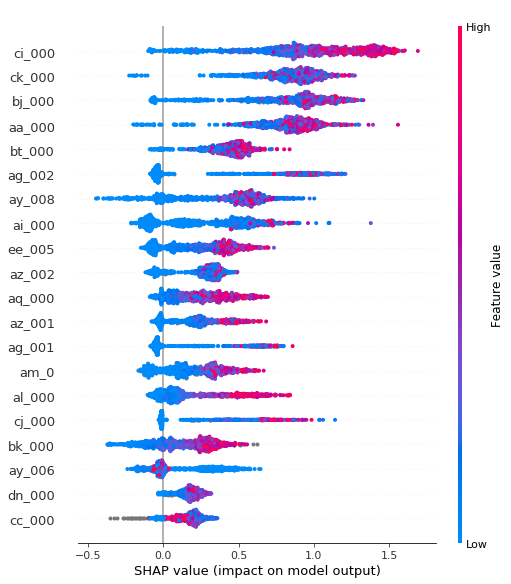

In [38]:
shap.summary_plot(shap_values, all_X_valid[all_y_valid==1])

## Looking at misclassified Class 1 

In [44]:
missed_class_1 = all_X_valid[(all_y_valid==1)&(all_y_valid!=(results.predicted_probability >= treshold))]

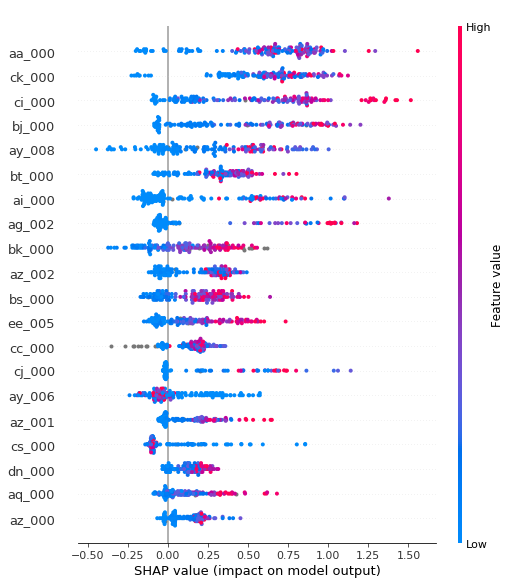

In [46]:
shap_values = explainer.shap_values(missed_class_1)

shap.summary_plot(shap_values, missed_class_1)

## Looking at correctly classified Class 1 

In [47]:
correct_class_1 = all_X_valid[(all_y_valid==1)&(all_y_valid==(results.predicted_probability >= treshold))]

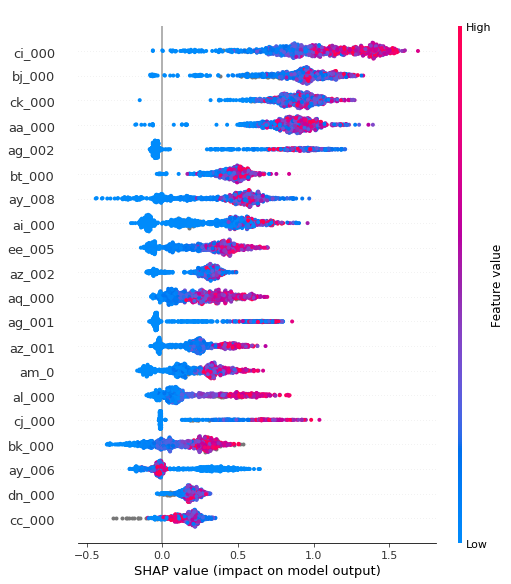

In [48]:
shap_values = explainer.shap_values(correct_class_1)

shap.summary_plot(shap_values, correct_class_1)

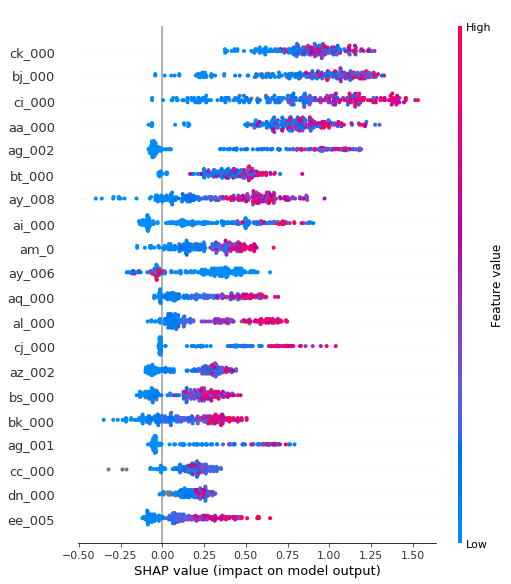

In [81]:
correct_class_1 = all_X_valid[(all_y_valid==1)&(results["system_age"]=="low")&(all_y_valid==(results.predicted_probability >= treshold))]
shap_values = explainer.shap_values(correct_class_1)


shap.summary_plot(shap_values, correct_class_1)

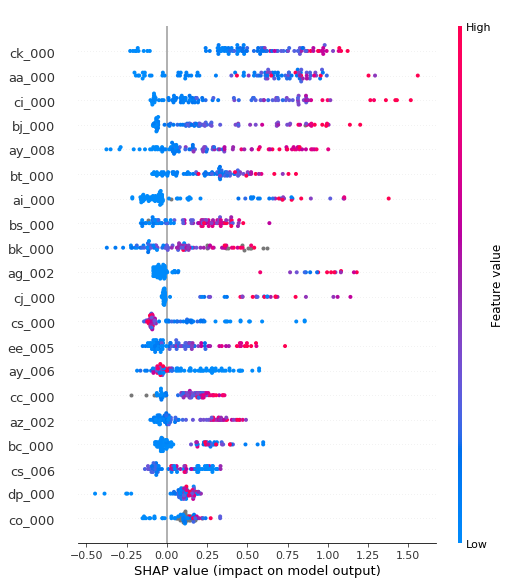

In [84]:
correct_class_1 = all_X_valid[(all_y_valid==1)&(results["system_age"]=="low")&(all_y_valid!=(results.predicted_probability >= treshold))]
shap_values = explainer.shap_values(correct_class_1)


shap.summary_plot(shap_values, correct_class_1)

In [106]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
params = {'boosting_type': 'gbdt',
 'feature_fraction': 0.3768261055064843,
 'learning_rate': 0.0668457974368219,
 'max_depth': 6,
 'min_child_samples': 220,
 'min_child_weight': 27.460369817131145,
 'num_leaves': 590,
 'reg_alpha': 0.4999057288562867,
 'reg_lambda': 0.29964409552070514,
 'subsample': 0.7553625889348823,
 'subsample_for_bin': 180000,
 'is_unbalanced': False,
 'scale_pos_weight': 58.298024096093584}

treshold = 0.08174049320688517
beta = 7.514521379406827
num_boost_rounds = 192

data_for_lightgbm = data_for_lightgbm.replace(-1,np.nan)
X = data_for_lightgbm[data_for_lightgbm.origin=="train"].drop(["Class","origin"],axis=1)
y = data_for_lightgbm[data_for_lightgbm.origin=="train"]["Class"]
X_test = data_for_lightgbm[data_for_lightgbm.origin=="test"].drop(["Class","origin"],axis=1)
y_test = data_for_lightgbm[data_for_lightgbm.origin=="test"]["Class"]



In [107]:

lgb_all = lgb.Dataset(X, y, free_raw_data=False)
gbm = lgb.train(params,
                lgb_all,
                num_boost_round=num_boost_rounds,
                #valid_sets=lgb_eval,  # eval training data
                #early_stopping_rounds = 100, 
                fobj= logregobjspecial(beta),
                feval=create_evalmoney(treshold),
               )


In [108]:

y_test_pred = gbm.predict(X_test)
y_test_pred = 1. / (1. + np.exp(-y_test_pred))
#y_test = test_original["class"]
confusion_matrix(y_test,y_test_pred>treshold)

array([[15248,   377],
       [   12,   363]])

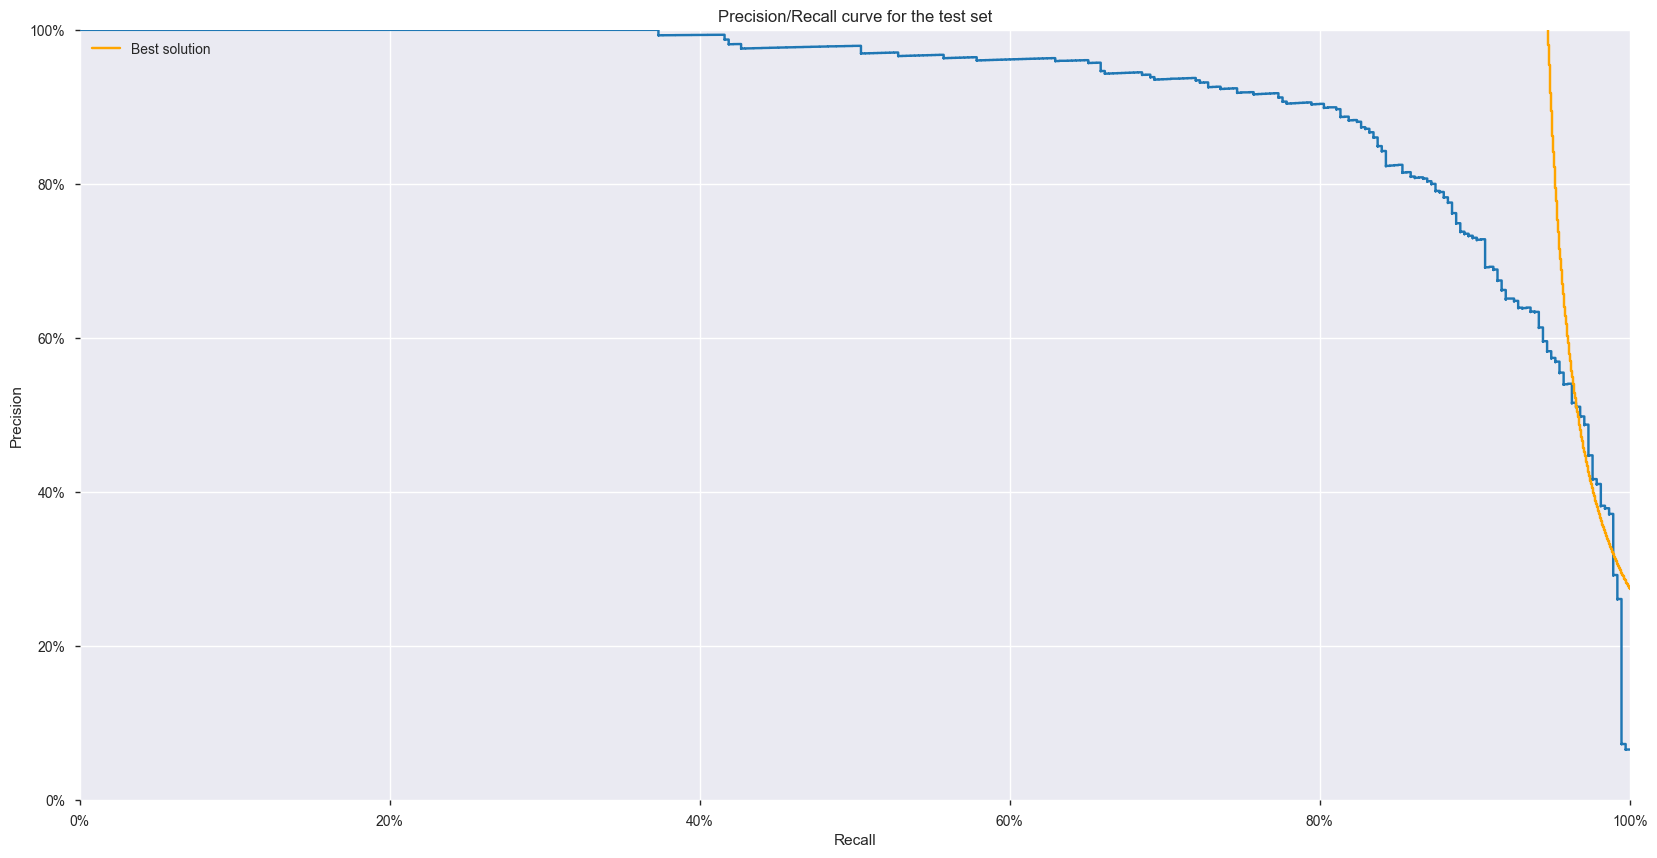

In [33]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
graph_curve(y_test,y_test_pred);
plt.step(best_limit_x,best_limit_y,color="orange",label="Best solution")
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.xaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0,1);
plt.xlim(0,1);
plt.title("Precision/Recall curve for the test set");

## LightGBM results

The lightGBM are already the equivalent of the best results published.
We notice that the lowest recall is still of the "younger" system age.

## Random forest model

Another model we can use without feature engineering is Random Forest.

The only difference between Random Forest and LighGBM  is that we need to handle missing values.
It is tree based, so we still do not need to take care about scaling, but it does not handle missing values very well.

Remarkably enough, the train and test set have exactly the same amount of missing values per features.


In [100]:
train_original = pd.read_csv('aps_failure_training_set.csv',skiprows=20)
train_original = pre_processing(train_original,np.nan)
test_original = pd.read_csv('aps_failure_test_set.csv',skiprows=20)
test_original = pre_processing(test_original,np.nan)

In [101]:
X = train_original.drop("class",axis=1)
y = train_original["class"]

X_test = test_original.drop("class",axis=1)
y_test = test_original["class"]
# Model each feature with missing values as a function of other features, and
# use that estimate for imputation.

train_filled_svd = SoftImpute().fit_transform(X)
test_filled_svd = SoftImpute().fit_transform(X_test)

[SoftImpute] Max Singular Value of X_init = 207329831370.562134
[SoftImpute] Iter 1: observed MAE=390300.971898 rank=5
[SoftImpute] Iter 2: observed MAE=386907.249281 rank=5
[SoftImpute] Iter 3: observed MAE=386471.559811 rank=5
[SoftImpute] Iter 4: observed MAE=386681.004088 rank=5
[SoftImpute] Iter 5: observed MAE=387014.233842 rank=5
[SoftImpute] Iter 6: observed MAE=387319.963295 rank=5
[SoftImpute] Iter 7: observed MAE=387569.012661 rank=5
[SoftImpute] Iter 8: observed MAE=387762.655529 rank=5
[SoftImpute] Iter 9: observed MAE=387909.438534 rank=5
[SoftImpute] Iter 10: observed MAE=388019.855236 rank=5
[SoftImpute] Iter 11: observed MAE=388102.876667 rank=5
[SoftImpute] Iter 12: observed MAE=388165.691919 rank=5
[SoftImpute] Iter 13: observed MAE=388213.534691 rank=5
[SoftImpute] Iter 14: observed MAE=388250.261543 rank=5
[SoftImpute] Iter 15: observed MAE=388278.811688 rank=5
[SoftImpute] Iter 16: observed MAE=388301.223309 rank=5
[SoftImpute] Iter 17: observed MAE=388319.022039 

[SoftImpute] Iter 59: observed MAE=386093.938167 rank=4
[SoftImpute] Iter 60: observed MAE=386094.796424 rank=4
[SoftImpute] Iter 61: observed MAE=386095.638348 rank=4
[SoftImpute] Iter 62: observed MAE=386096.465511 rank=4
[SoftImpute] Iter 63: observed MAE=386097.277925 rank=4
[SoftImpute] Iter 64: observed MAE=386098.075351 rank=4
[SoftImpute] Iter 65: observed MAE=386098.858052 rank=4
[SoftImpute] Iter 66: observed MAE=386099.626096 rank=4
[SoftImpute] Iter 67: observed MAE=386100.379625 rank=4
[SoftImpute] Iter 68: observed MAE=386101.119082 rank=4
[SoftImpute] Iter 69: observed MAE=386101.844698 rank=4
[SoftImpute] Iter 70: observed MAE=386102.556590 rank=4
[SoftImpute] Iter 71: observed MAE=386103.254865 rank=4
[SoftImpute] Iter 72: observed MAE=386103.939812 rank=4
[SoftImpute] Iter 73: observed MAE=386104.611744 rank=4
[SoftImpute] Iter 74: observed MAE=386105.270952 rank=4
[SoftImpute] Iter 75: observed MAE=386105.917822 rank=4
[SoftImpute] Iter 76: observed MAE=386106.552330

In [ ]:
params = {'bootstrap': False, 'class_weight': {0: 1, 1: 500}, 'criterion': 'entropy'
         ,'max_depth': 470, 'max_features': 60, 'min_samples_leaf': 90
         ,'min_samples_split': 15, 'n_estimators': 470}

pred_prob_valid = []
X_valids = []
y_valids = []
eval_results = []
models = []
#the_total_columns = [f"{hist}_total" for hist in hists]
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
for train_index, valid_index in skf.split(X,y):
    evals_result = {}
    X_train, X_valid = train_filled_svd[train_index], train_filled_svd[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    rfc =  RandomForestClassifier(**params,n_jobs=-1)
    rfc.fit(X_train,y_train)
    eval_results.append(evals_result)
    pred_prob = rfc.predict_proba(X_valid)
    pred_prob_valid.append(pred_prob[:,1])
    y_valids.append(y_valid)
    X_valids.append(X_valid)

In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
for y,pred in zip(y_valids,pred_prob_valid):
    pred = 1. / (1. + np.exp(-pred))
    graph_curve(y,pred)

best_limit_x = []
best_limit_y = []
for false_neg in range(0,200):
    false_neg = false_neg/10
    true_pos = 375 - false_neg
    recall = true_pos/375
    false_pos = 9920/10 - 50*false_neg
    precision = true_pos/(true_pos+false_pos)
    best_limit_x.append(recall)
    best_limit_y.append(precision)
    
plt.step(best_limit_x,best_limit_y,color="orange",label="Best solution")
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.xaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0,1);
plt.xlim(0,1);
plt.title("Precision/Recall curve for the validation set");

In [102]:
params = {'bootstrap': False, 'class_weight': {0: 1, 1: 500}, 'criterion': 'entropy', 'max_depth': 470, 'max_features': 60, 'min_samples_leaf': 90, 'min_samples_split': 15, 'n_estimators': 470}
rfc_best_svn_2 =  RandomForestClassifier(**params,n_jobs=-1)
%time rfc_best_svn_2.fit(train_filled_svd, y)



CPU times: user 25min 8s, sys: 5.67 s, total: 25min 14s
Wall time: 7min 14s


RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 500},
            criterion='entropy', max_depth=470, max_features=60,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=90,
            min_samples_split=15, min_weight_fraction_leaf=0.0,
            n_estimators=470, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [103]:
pred_svn_2 = rfc_best_svn_2.predict(test_filled_svd)
confusion_matrix(y_test,pred_svn_2)

array([[15083,   542],
       [    9,   366]])

## The Random forest result

The results from the random forest is also also the equivalent of the best existing result (that was 9, 542).
But as the LightGBM and RF are very close and the use different methodology, there is a likelyhood that using both can improve the final results.

## Model stacking

We are looking to reduce the number of false negative, so we will look at using a "OR" function between the 2 results form the Random forest and LightGBM.

In [104]:
print("Number of positive from lightGBM: ",sum(y_test_pred>=treshold))
print("Number of positive from Random Forest: ",sum(pred_svn_2))
print("Number of positive from using both model: ",sum((y_test_pred>=treshold)|(pred_svn_2)))

Number of positive from lightGBM:  737
Number of positive from Random Forest:  908
Number of positive from using both model:  961


The total number of postive increased, which means that the number of false positives has increased, but at the same time have less false negatives.

Let's look at the results...

In [109]:
confusion_matrix(y_test,(y_test_pred>=treshold)|(pred_svn_2))

array([[15038,   587],
       [    5,   370]])

### Model stacking result

Stacking the model improves the best published result for a total cost of \\$8 370 (down from \\$9 920.)

Let's see if we can create a third model that would help us improve the results.

## Feature engineering for histograms

As we have an histograms, we can infer the average of each of the variable.

The advantage of doing that is to see if there is a particular value that is indicative of early failure of the system early in the life of the system.

Looking at the distributions and average, we notice that failing system for "low" total feature have a higher BA average value (ba_avg) and a lower CS average (cs_avg), but would this be enough to improve our precision for the "low" band with our simple lightGBM model ?

In [49]:
for hist in hists:
    data[f"{hist}_total"] = sum(data[col] for col in hists_dict[hist])
data = data.replace(-10,-1) #Some totals of -1 to make it easy to detect NA


for hist in hists:
    data[f"{hist}_avg"] = 0
    for col in hists_dict[hist]:
        data[f"{col}_density"] = data[col]/data[f"{hist}_total"]
        data.loc[data[f"{hist}_total"] == -10, f"{col}_density"] = -1
        data.loc[data[f"{hist}_total"] == 0, f"{col}_density"] = 0
        data[f"{hist}_avg"] += int(col[3:])*data[col]
    data[f"{hist}_avg"] = data[f"{hist}_avg"]/data.system_age
    data.loc[data[f"{hist}_total"] == 0, f"{hist}_avg"] = 0
    data.loc[data[f"{hist}_total"] == -1, f"{hist}_avg"] = 0

data = data.drop([f"{hist}_total" for hist in hists],axis=1)


In [51]:
bins_for_total_feature[3] = np.max(data.system_age)
data["total_cat"] = pd.cut(data.system_age.replace(np.nan,-1),[-10.1] + list(bins_for_total_feature)
                        ,labels=["null","low", "medium", "high"])

In [52]:
pds_to_concat = []
for i,hist in enumerate(hists):
    temp = data[data.total_cat!="null"][[f"{hist}_avg",'Class',"total_cat"]]
    temp["ref"] = f"{hist}_avg"
    #temp.loc[temp[f"{hist}_avg"]>=0,f"{hist}_avg"] = np.log(temp[f"{hist}_avg"]+1)
    temp.columns = ["data","Class","total_cat","ref"]
    pds_to_concat.append(temp)
all_avg_vals = pd.concat(pds_to_concat)


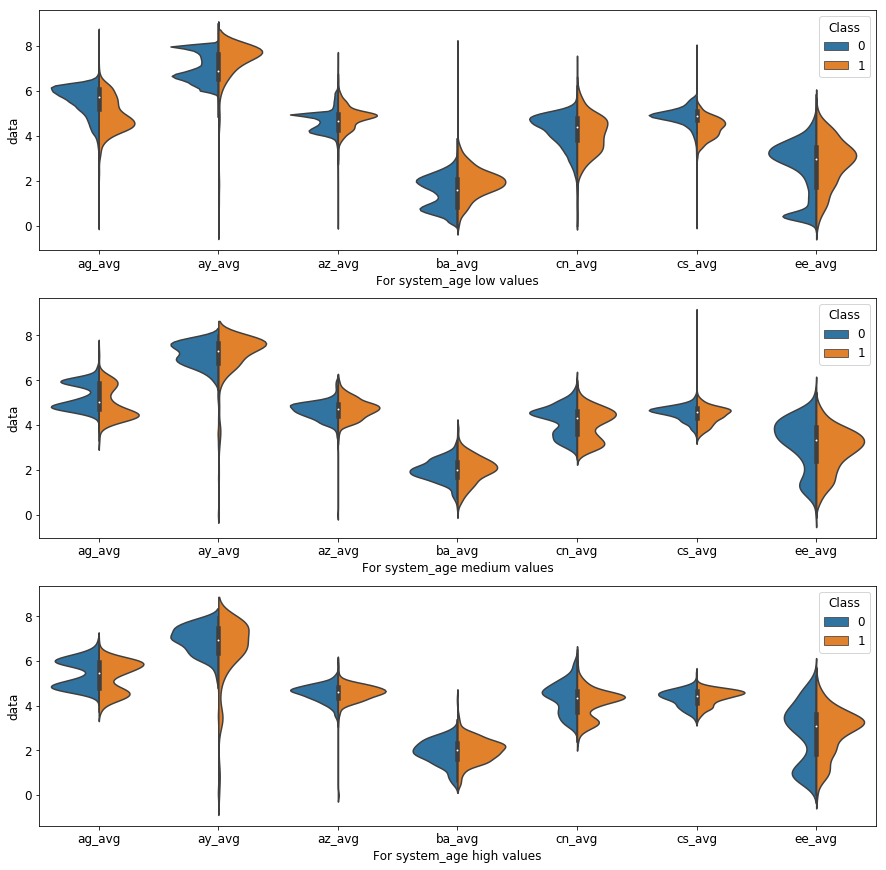

In [53]:
categories_to_display = data.total_cat.cat.categories[1:]
plt.rcParams.update({'font.size': 12})


fig , axs = plt.subplots(len(categories_to_display))
fig.set_figheight(15)
fig.set_figwidth(15)
#sns.boxenplot(data=ag_dist,x="ref",y="data",hue="class",outlier_prop=0.00000000001)
for ax,cat in zip(axs,categories_to_display):
    g = sns.violinplot(data=all_avg_vals[all_avg_vals.total_cat==cat]
                  , x="ref",y="data",hue="Class",split=True
                  , ax = ax)
    g.set_xlabel(f"For system_age {cat} values")
#fig.text(0.04, 0.5, 'Distribution of each feature per outcome', va='center', rotation='vertical');

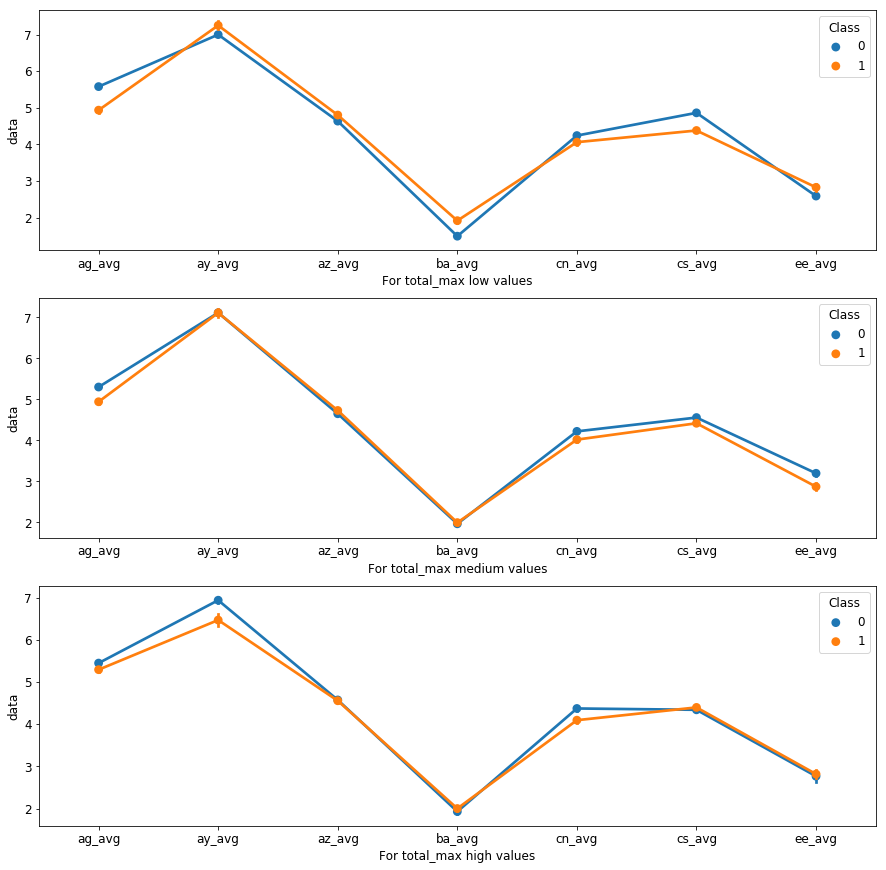

In [54]:
categories_to_diplay = data.total_cat.cat.categories[1:]
fig , axs = plt.subplots(len(categories_to_diplay))
fig.set_figheight(15)
fig.set_figwidth(15)
#sns.boxenplot(data=ag_dist,x="ref",y="data",hue="class",outlier_prop=0.00000000001)
for ax,cat in zip(axs,categories_to_diplay):
    g = sns.pointplot(data=all_avg_vals[all_avg_vals.total_cat==cat]
                  , x="ref",y="data",hue="Class"
                  , ax = ax)
    g.set_xlabel(f"For total_max {cat} values")
#fig.text(0.04, 0.5, 'Distribution of each feature per outcome', va='center', rotation='vertical');

# Linear Methods

Let's now try out Linear Regression, for that we need a little more work of preparing the data.
First we need to handle the missing values.

Previously we just input then, but this thime, let's try to scale then before we input then. We will replace then byt the median value initially, scale the features.

Once they are scaled, we will put the missing values in place and input then.

In [55]:
#Log where the NA are
for col in data.columns:
    data[f"{col}_isna"] = False
    data.loc[data[col].isna(),f"{col}_isna"] = True

In [56]:
data = data.fillna(data.median())


In [57]:
isna_cols = [col for col in data.columns if "_isna" in col]

In [58]:
data_for_scaling = data.drop(["Class","origin","index","total_cat"]+isna_cols,axis=1)

In [60]:
from sklearn.preprocessing import StandardScaler
robust_scaler = StandardScaler()
data_robust_scaler = robust_scaler.fit_transform(data_for_scaling)
#test_filled_svd_robust_scaler = robust_scaler.transform(test_filled_svd)

Looking at the data, there are a few very big values left due to the scaler, let's Winsoring then (only taking out 1%).

In [61]:
from scipy.stats.mstats import winsorize

In [62]:
for col in range(data_robust_scaler.shape[1]):
    print(col,np.min(data_robust_scaler[col,:]),np.max(data_robust_scaler[col,:]))

0 -0.7903831403448264 2.547399312244418
1 -1.7385233983091153 2.146544867418551
2 -0.8563886485127353 1.3257293543659423
3 -1.6718105792436757 3.182804897261416
4 -0.9504264443946019 1.459283101121662
5 -0.9234631071726594 2.3092868116347876
6 -1.7385233983091153 1.8154928832792645
7 -1.228464084658224 6.549208137035173
8 -1.7385233983091153 1.6461301271602753
9 -1.7404099515534732 4.638924526542921
10 -1.0176740506057496 1.9962376150461112
11 -1.1426232953450295 1.4772809511537508
12 -1.8691343244169187 3.8788634548795495
13 -0.96483881740191 5.967073480027412
14 -1.7385233983091153 3.991788591159692
15 -1.6131579540462766 1.9303876830128406
16 -1.4953667618612612 9.95153726668513
17 -1.519480058252334 2.6280059166412912
18 -1.3464767509539413 2.3092868116347876
19 -1.8044391507396162 2.9267815895984928
20 -1.476229437301402 3.564828340927487
21 -1.6697111514123832 2.4698727675623027
22 -1.0176730830130933 4.270789166724352
23 -1.7385233983091153 13.321655618448164
24 -0.6181998611658

In [63]:
data_robust_scaler_winsorized = winsorize(data_robust_scaler, limits=0.01, inplace=False, axis=1)

In [64]:
for col in range(data_robust_scaler_winsorized.shape[1]):
    print(col,np.min(data_robust_scaler_winsorized[col,:]),np.max(data_robust_scaler_winsorized[col,:]))

0 -0.7464771019592477 1.8366630326583555
1 -0.9217551343365741 0.7576978783094274
2 -0.7998145005737788 0.829748300920555
3 -1.0870066377216614 1.7637928584964306
4 -0.6056390693462362 1.289710375752787
5 -0.6118334141804824 1.3085008585530762
6 -1.1952733790841528 1.7229144034148702
7 -0.8567176907044021 2.3092868116347876
8 -0.9474326963607137 1.3240306017660222
9 -1.148723730774014 2.6638770830846137
10 -0.7752761181776703 1.1294750101789428
11 -0.7930665505198279 0.9857161012709813
12 -1.660780204854878 1.9307258128684441
13 -0.9033916912736528 4.093623540905385
14 -0.7607866417095182 3.7717371654355896
15 -1.1452057035064618 1.7217186398137998
16 -1.0163542721364756 6.781105551374029
17 -1.0627744866358606 1.7173076543296262
18 -1.0176740506057496 1.969403221600603
19 -0.8177778384280981 2.3092868219311717
20 -0.9841975440424642 2.2222408964032363
21 -1.2900866493677239 1.9356661778750774
22 -0.718351935325486 2.8126001452050824
23 -0.8559719786115616 12.275474971457042
24 -0.5994

In [65]:
#scaled_data = pd.DataFrame(data=data_robust_scaler,columns=data_for_scaling.columns,index=data_for_scaling.index)
scaled_data = pd.DataFrame(data=data_robust_scaler_winsorized,columns=data_for_scaling.columns,index=data_for_scaling.index)





In [66]:
for col in scaled_data.columns:
    scaled_data.loc[data[f"{col}_isna"]==True,col] = np.nan



In [67]:

X = scaled_data[data.origin=="train"]
X_test = scaled_data[data.origin=="test"]

y = data[data.origin=="train"].Class
y_test = data[data.origin=="test"].Class



In [69]:
fill_na = IterativeImputer()
train_filled_svd = fill_na.fit_transform(X)

In [70]:
test_filled_svd = fill_na.fit_transform(X_test)

In [71]:
train_filled_svd.shape

(60000, 250)

In [72]:
from sklearn.decomposition import PCA

n_components = 150
whiten = True


pca = PCA(n_components=n_components, whiten=whiten)

X_train_PCA = pca.fit_transform(train_filled_svd)

In [73]:
X_test_pca = pca.transform(test_filled_svd)

In [76]:
pred_prob_valid = []
X_valids = []
y_valids = []
weight = sum(y == 0)/sum(y == 1)
C_ = 0.00005
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
for train_index, valid_index in skf.split(X_train_PCA, Y):
    evals_result = {}
    X_train, X_valid = X_train_PCA[train_index], X_train_PCA[valid_index]
    y_train, y_valid = Y.iloc[train_index], Y.iloc[valid_index]
    log_reg_pca = LogisticRegression(C = C_,tol=0.00001
                                 , class_weight={1:100}
                                 , solver='saga'
                                 ,n_jobs=-1
                                 ,penalty="l1"
                                 #,max_iter=500
                                 #,warm_start=True
                                )
    log_reg_pca.fit(X_train, y_train)
    pred_prob = log_reg_pca.predict_proba(X_valid)
    pred = log_reg_pca.predict(X_valid)
    pred_prob_valid.append(pred_prob[:,1])
    print("Precision: ",precision_score(y_valid,pred))
    print("Recall: ",recall_score(y_valid,pred))
    y_valids.append(y_valid)
    X_valids.append(X_valid)

Precision:  0.2361111111111111
Recall:  0.85
Precision:  0.2543859649122807
Recall:  0.87
Precision:  0.24088541666666666
Recall:  0.925
Precision:  0.2391304347826087
Recall:  0.935
Precision:  0.23834196891191708
Recall:  0.92


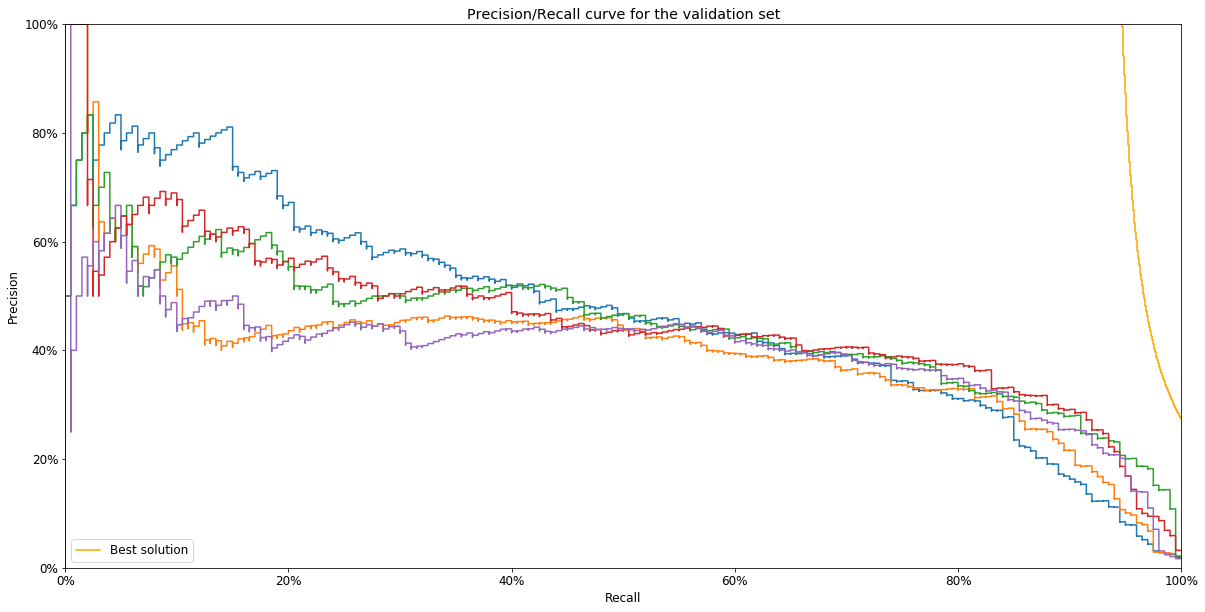

In [77]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
for y,pred in zip(y_valids,pred_prob_valid):
    pred = 1. / (1. + np.exp(-pred))
    graph_curve(y,pred)

best_limit_x = []
best_limit_y = []
for false_neg in range(0,200):
    false_neg = false_neg/10
    true_pos = 375 - false_neg
    recall = true_pos/375
    false_pos = 9920/10 - 50*false_neg
    precision = true_pos/(true_pos+false_pos)
    best_limit_x.append(recall)
    best_limit_y.append(precision)
    
plt.step(best_limit_x,best_limit_y,color="orange",label="Best solution")
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(PercentFormatter(1))
ax.xaxis.set_major_formatter(PercentFormatter(1))
plt.ylim(0,1);
plt.xlim(0,1);
plt.title("Precision/Recall curve for the validation set");

## Logistic regression evaluation after cross validation

The recall and precision during cross-validation were lower than for the lightGBM and Random Forest, there will be no benefit to use then to improve the previous results as it will increase the number of false positives.

But the result is still correct and will benefit from being improved.

https://github.com/hyperopt/hyperopt/issues/267
https://blog.goodaudience.com/on-using-hyperopt-advanced-machine-learning-a2dde2ccece7